<a href="https://colab.research.google.com/github/Elaine2211/CNN/blob/master/Transferlearing_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [0]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()


--2020-01-30 18:53:55--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   122MB/s    in 0.7s    

2020-01-30 18:53:56 (122 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in

In [0]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [0]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        


In [0]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2020-01-30 18:54:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   188MB/s    in 0.8s    

2020-01-30 18:54:15 (188 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-01-30 18:54:15--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [applicati

In [0]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses') 
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses') 
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))


500
527
128
128


In [0]:
# Add data-augmentation parameters to ImageDataGenerator to decrease overfitting
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# The validation data should not be augmented
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [0]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/100
Epoch 1/100
100/100 - 37s - loss: 0.1963 - acc: 0.9220 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 2/100
Epoch 1/100
100/100 - 27s - loss: 0.0692 - acc: 0.9721 - val_loss: 0.0056 - val_acc: 0.9960
Epoch 3/100
Epoch 1/100
100/100 - 26s - loss: 0.0473 - acc: 0.9833 - val_loss: 0.0333 - val_acc: 0.9960
Epoch 4/100
Epoch 1/100
100/100 - 26s - loss: 0.0505 - acc: 0.9844 - val_loss: 0.0210 - val_acc: 0.9960
Epoch 5/100
Epoch 1/100
100/100 - 26s - loss: 0.0471 - acc: 0.9868 - val_loss: 0.0693 - val_acc: 0.9838
Epoch 6/100
Epoch 1/100
100/100 - 25s - loss: 0.0355 - acc: 0.9883 - val_loss: 0.0485 - val_acc: 0.9919
Epoch 7/100
Epoch 1/100
100/100 - 25s - loss: 0.0236 - acc: 0.9914 - val_loss: 0.1642 - val_acc: 0.9767
Epoch 8/100
Epoch 1/100
100/100 - 25s - loss: 0.0304 - acc: 0.9894 - val_loss: 0.1278 - val_acc: 0.9838
Epoch 9/100
Epoch 1/100
100/100 - 25s - loss: 0.0233 - acc: 0.9919 - val_loss: 0.1080 - val_acc: 0.9919
Epoch 10/100
Epoch 1/100
100/100 - 26s - loss: 0.0277 - acc: 0.9

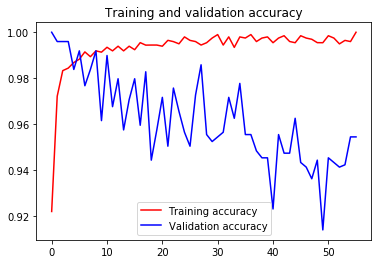

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()